<a href="https://colab.research.google.com/github/gibsonx/tf_skeleton/blob/master/tf_keypoint_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [251]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!git clone https://github.com/gibsonx/tf_skeleton.git

fatal: destination path 'tf_skeleton' already exists and is not an empty directory.


In [ ]:
!pip install -r /content/tf_skeleton/requirements.txt > /dev/null

In [1]:
from pycocotools.coco import COCO
import numpy as np
import os.path
from typing import Any, Callable, List, Optional, Tuple
from PIL import Image
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os, json, cv2, numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

from keras.models import Sequential

from keras.layers import (
    Flatten,
    Dense,
    Dropout,
    Conv2D,
    LeakyReLU,
    BatchNormalization,
    MaxPool2D,
)
from imgaug import augmenters as iaa
import imgaug as ia
import imageio

from imgaug.augmentables.kps import Keypoint, KeypointsOnImage
import math

In [2]:
train_img_dir="/content/drive/MyDrive/Dataset/aspine20230930/image_train"
val_img_dir="/content/drive/MyDrive/Dataset/aspine20230930/image_val"
val_annotations_file="/content/drive/MyDrive/Dataset/aspine20230930/annotations/person_keypoints_Validation.json"
train_annotations_file="/content/drive/MyDrive/Dataset/aspine20230930/annotations/person_keypoints_Train.json"

In [65]:
class DataframeMaker():

    def __init__(self,img_path,annotations_file):
        self.img_path = img_path
        self.coco = COCO(annotations_file)
        self.imgIds = self.coco.getImgIds()
        self.dataframe = None
        self.__build__()

    def __build__(self):
        """
        read annotation and build dataframe
        :return:
        """

        kps_metrix = []
        image_list = []

        for id in self.imgIds:

          # load a image
          img = self.coco.loadImgs(id)[0]
          imgPath = img['file_name']


          ann=self.coco.loadAnns(self.coco.getAnnIds(imgIds=img['id']))

          keypoints_original = [[list(a) for a in zip(*[iter(ann[0]['keypoints'])]*3)]]

          kps_row = []
          for kp in keypoints_original:
              for el in kp:
                  kps_row.extend(el[0:2])
          kps_row.append(imgPath)

          kps_metrix.append(kps_row)

        df = pd.DataFrame(kps_metrix)

        self.dataframe = df

    def _transformed_dataset(self, img_height, img_width):
      """
      :param img_height:
      :param img_width:
      :return:
      """

      ts_kps_metrix = []
      ts_image_list = []

      for index, row in self.dataframe.iterrows():


        annotations = row[:32]
        converted_keypoints = [list(a) for a in zip(*[iter(annotations)]*2)]

        image = row[-1:].item()

        fullImgPath = os.path.join(self.img_path,image)

        open_cv_image = np.array(Image.open(fullImgPath))

        kps = [Keypoint(x=coodination[0], y=coodination[1]) for coodination in converted_keypoints]
        kpsoi = KeypointsOnImage(kps, shape=open_cv_image.shape)

        ia.seed(1)

        seq = iaa.Sequential([
            iaa.Resize({"height": img_height, "width": img_width})
        ])

        image_aug, kpsoi_aug = seq(image=open_cv_image, keypoints=kpsoi)

        ts_kps_row = []

        for i in range(len(kpsoi_aug.keypoints)):
            after = kpsoi_aug.keypoints[i]
            ts_kps_row.extend([after.x,after.y])

        ts_kps_metrix.append(ts_kps_row)
        ts_image_list.append(image_aug)


      df = pd.DataFrame(ts_kps_metrix)

      df['image'] = ts_image_list

      return df

In [66]:
val_df = DataframeMaker(val_img_dir,val_annotations_file)
train_df = DataframeMaker(train_img_dir,train_annotations_file)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [67]:
val_trdf = val_df._transformed_dataset(1000,560)

In [68]:
def show_image(kps, image, image_path):

    fullImgPath = os.path.join(image_path,image)
    open_cv_image = np.array(Image.open(fullImgPath))
    converted_keypoints = [list(a) for a in zip(*[iter(kps)]*2)]

    kps = [Keypoint(x=coodination[0], y=coodination[1]) for coodination in converted_keypoints]

    kpsoi = KeypointsOnImage(kps, shape=open_cv_image.shape)

    image_with_kps = kpsoi.draw_on_image(open_cv_image, size=15)

    plt.imshow(image_with_kps)

def show_tran_image(kps, image):

    open_cv_image = np.array(image)
    converted_keypoints = [list(a) for a in zip(*[iter(kps)]*2)]

    kps = [Keypoint(x=coodination[0], y=coodination[1]) for coodination in converted_keypoints]

    kpsoi = KeypointsOnImage(kps, shape=open_cv_image.shape)

    image_with_kps = kpsoi.draw_on_image(open_cv_image, size=15)

    plt.imshow(image_with_kps)

Visualize a simple image

In [69]:
rand_number = np.random.randint(0,len(val_df.dataframe))
print(rand_number)
n = rand_number

21


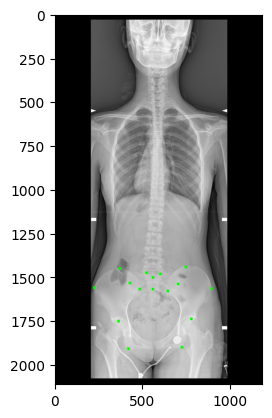

In [70]:
X, Y = val_df.dataframe.loc[n-1][0:32], val_df.dataframe.loc[n-1][-1:].item()
show_image(X,Y,val_img_dir)

In [124]:
X, Y = val_trdf.iloc[n-1,:32], val_trdf.iloc[n-1,-1:]
print(np.stack(val_trdf.loc[0:3,'image']).shape)

val_trdf.loc[0:3,:31]

(4, 1000, 560, 3)


,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,171.112167,714.119324,404.618896,716.396790,108.443245,769.696960,439.756104,762.182800,228.616211,793.058716,...,218.991226,972.476379,391.739868,976.567261,264.127014,716.368347,293.125000,716.742432,278.784454,717.012268
1,167.205399,693.200745,421.688538,698.518005,113.031075,788.674316,473.431732,799.838989,221.876343,758.906311,...,213.575684,950.781311,353.135834,953.319153,262.301361,697.026489,301.255402,694.995239,284.384491,699.086182
2,147.383102,716.718750,392.922302,710.994324,97.919601,788.707397,445.015564,788.783142,220.438522,780.525574,...,203.397293,978.295410,344.797302,974.876892,243.514847,717.405334,284.294586,717.059692,266.619598,722.916687
3,171.254059,717.566284,376.354034,723.996155,106.418915,781.103210,426.763519,770.634460,220.012848,793.072876,...,202.971634,975.667664,341.623627,983.498962,250.278351,724.881592,297.249329,728.134460,273.983795,728.385376


In [10]:
coco = COCO(val_annotations_file)
img = coco.loadImgs(rand_number)
print(img)
print("df:",val_df.dataframe.loc[n-1][-1:].item())
ann = coco.loadAnns(coco.getAnnIds(imgIds=img[0]['id']))[0]['keypoints']
print(ann)
print("df ann:",list(val_df.dataframe.loc[n-1][0:32]))

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
[{'id': 17, 'width': 1184, 'height': 2112, 'file_name': 'img-00086-00001.jpg', 'license': 0, 'flickr_url': '', 'coco_url': '', 'date_captured': 0}]
df: img-00086-00001.jpg
[407.54, 1498.6, 2, 791.33, 1480.75, 2, 273.52, 1637.14, 2, 919.68, 1613.97, 2, 477.89, 1618.62, 2, 705.44, 1603.18, 2, 483.13, 1549.41, 2, 728.34, 1548.69, 2, 590.7, 1593.42, 2, 398.52, 1785.59, 2, 796.49, 1771.78, 2, 445.64, 1938.81, 2, 751.3, 1899.29, 2, 544.86, 1487.91, 2, 615.1, 1483.91, 2, 582.41, 1492.25, 2]
df ann: [407.54, 1498.6, 791.33, 1480.75, 273.52, 1637.14, 919.68, 1613.97, 477.89, 1618.62, 705.44, 1603.18, 483.13, 1549.41, 728.34, 1548.69, 590.7, 1593.42, 398.52, 1785.59, 796.49, 1771.78, 445.64, 1938.81, 751.3, 1899.29, 544.86, 1487.91, 615.1, 1483.91, 582.41, 1492.25]


In [125]:
class DataGenerator(tf.keras.utils.Sequence):

    def __init__(self, img_path, dataframe, batch_size, img_height, img_width):
        self.img_path = img_path
        self.df = dataframe
        self.batch_size = batch_size
        self.img_height = img_height
        self.img_width = img_width

    def __len__(self):
        return math.ceil(len(self.df) / self.batch_size)

    def __getitem__(self, idx):
        low = idx * self.batch_size
        # Cap upper bound at array length; the last batch may be smaller
        # if the total number of items is not a multiple of batch size.
        high = min(low + self.batch_size, len(self.df))
        image = self._transformed_dataset.loc[low:high,'image']
        annotations = self._transformed_dataset.loc[low:high,:31]
        print(annotations.shape)
        # batch_x = image.iloc[low:high]
        # batch_y = annotations.iloc[low:high]

        return np.stack(image), annotations

    @property
    def _transformed_dataset(self):
      """
      :param height:
      :param width:
      :return:
      """

      ts_kps_metrix = []
      ts_image_list = []

      for index, row in self.df.iterrows():

        annotations = row[0:32]
        converted_keypoints = [list(a) for a in zip(*[iter(annotations)]*2)]

        image = row[-1:].item()

        fullImgPath = os.path.join(self.img_path,image)

        open_cv_image = np.array(Image.open(fullImgPath))

        kps = [Keypoint(x=coodination[0], y=coodination[1]) for coodination in converted_keypoints]
        kpsoi = KeypointsOnImage(kps, shape=open_cv_image.shape)

        ia.seed(1)

        seq = iaa.Sequential([
            iaa.Resize({"height": self.img_height, "width": self.img_width})
        ])

        image_aug, kpsoi_aug = seq(image=open_cv_image, keypoints=kpsoi)

        ts_kps_row = []

        for i in range(len(kpsoi_aug.keypoints)):
            after = kpsoi_aug.keypoints[i]
            ts_kps_row.extend([after.x,after.y])

        ts_kps_metrix.append(ts_kps_row)
        ts_image_list.append(image_aug)

      df = pd.DataFrame(ts_kps_metrix)
      image_array_list = [img for img in ts_image_list]
      df['image'] = image_array_list

      return df

In [126]:
height=1000
width=560
epoch_num = 1

training_generator = DataGenerator(train_img_dir,train_df.dataframe,3,height,width)
test_generator = DataGenerator(val_img_dir,val_df.dataframe,3,height,width)

In [102]:
model = Sequential([
    Conv2D(1, (5, 5), padding='same', use_bias=False, input_shape=(1000, 560, 3)),
    LeakyReLU(alpha=0.1),
    BatchNormalization(),
    MaxPool2D(pool_size=(2, 2)),

    Flatten(),
    Dense(512, activation='relu'),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(32)
])

In [ ]:
model.summary()

In [ ]:
# tf.keras.utils.plot_model(model, show_shapes=True)

In [104]:
model.compile(optimizer='adam',loss='mean_squared_error',metrics=['mae'])

In [ ]:
model.fit_generator(generator=training_generator,
                    validation_data=test_generator,
                    epochs=epoch_num)

<ipython-input-128-1a24be424bb0>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator=training_generator,


(4, 32)
(4, 32)
